In [1]:
from time import time
import matplotlib
#this will prevent the figure from popping up
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np
import pycuda.autoinit
from pycuda import gpuarray
from pycuda.elementwise import ElementwiseKernel
%matplotlib inline

### ElementwiseKernel kernel function

<b>pycuda::complex<float> *lattice </b>: 2D complex np array. The input of the kernel. The kernel function will run parallel on each of its elements. <br>
    
<b>float *mandelbrot_graph</b>: 2D float np array. The output of the kernel.<br>
    
<b>int max_iters</b>: np.int32 max iteration number<br>

<b>float upper_bound</b>: float, parameter of the fractal <br>

The kernel function will run parallel on each of its input elements. The 2D input and output matrices will be flattened and indexed by **i**.

In [2]:
### the kernel function ###

# ElementwiseKernel(inputs with their types, kernel code, kernel name)

mandel_ker = ElementwiseKernel(
"pycuda::complex<float> *lattice, float *mandelbrot_graph, int max_iters, float upper_bound",
"""
mandelbrot_graph[i] = 1;

pycuda::complex<float> c = lattice[i]; 
pycuda::complex<float> z(0,0);

for (int j = 0; j < max_iters; j++)
    {
    
     z = z*z + c;
     
     if(abs(z) > upper_bound)
         {
          mandelbrot_graph[i] = 0;
          break;
         }

    }
         
""",
"mandel_ker")


### Create a complex 2D latice

In [3]:
width=512 
height=512 
real_low=-2 
real_high=2 
imag_low=-2 
imag_high=2 
max_iters=256 
upper_bound=2


In [4]:
# we set up our complex lattice. This will be the kernel input
real_vals = np.matrix(np.linspace(real_low, real_high, width), dtype=np.complex64)
imag_vals = np.matrix(np.linspace( imag_high, imag_low, height), dtype=np.complex64) * 1j
mandelbrot_lattice = np.array(real_vals + imag_vals.transpose(), dtype=np.complex64)    

print(mandelbrot_lattice.shape)
print(type(mandelbrot_lattice))

(512, 512)
<class 'numpy.ndarray'>


In [5]:
print(mandelbrot_lattice[0,0])
print(mandelbrot_lattice[511,0])
print(mandelbrot_lattice[0,511])
print(mandelbrot_lattice[511,511])
print(mandelbrot_lattice[255,255])
print(mandelbrot_lattice[256,256])

(-2+2j)
(-2-2j)
(2+2j)
(2-2j)
(-0.0039138943+0.0039138943j)
(0.0039138943-0.0039138943j)


In [6]:
# copy complex lattice to the GPU
mandelbrot_lattice_gpu = gpuarray.to_gpu(mandelbrot_lattice)
print(mandelbrot_lattice_gpu.shape)
print(type(mandelbrot_lattice_gpu))

(512, 512)
<class 'pycuda.gpuarray.GPUArray'>


In [7]:
# allocate an empty array on the GPU
# this will be the output
mandelbrot_graph_gpu = gpuarray.empty(shape=mandelbrot_lattice.shape, dtype=np.float32)
print(mandelbrot_graph_gpu.shape)
print(type(mandelbrot_graph_gpu))

(512, 512)
<class 'pycuda.gpuarray.GPUArray'>


In [8]:
#calling the kernel function on GPU
t1 = time()
mandel_ker( mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound))
t2 = time()

mandel_time = t2 - t1
print(f'It took {mandel_time} seconds to calculate the Mandelbrot graph.')

It took 0.2143235206604004 seconds to calculate the Mandelbrot graph.


**Let us call the kernel function once more**

In [9]:
#calling the kernel function on GPU
t1 = time()
mandel_ker( mandelbrot_lattice_gpu, mandelbrot_graph_gpu, np.int32(max_iters), np.float32(upper_bound))
t2 = time()
mandel_time = t2 - t1
print(f'It took {mandel_time} seconds to calculate the Mandelbrot graph.')

It took 0.00017714500427246094 seconds to calculate the Mandelbrot graph.


**It was much faster at the second time** <br>
The first time pycuda had to compile the kernel function, the second time we don't need to compile it anymore.


### Show the results

In [10]:
# get the results back to CPU
mandelbrot_graph = mandelbrot_graph_gpu.get()

It took 0.11837959289550781 seconds to dump the image.


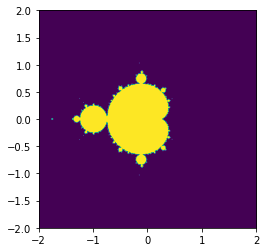

In [11]:
t1 = time()
fig = plt.figure(1)
plt.imshow(mandelbrot_graph, extent=(-2, 2, -2, 2))
plt.savefig('mandelbrot.png', dpi=fig.dpi)
t2 = time()

dump_time = t2 - t1
print(f'It took {dump_time} seconds to dump the image.')

In [12]:
print(type(mandelbrot_graph_gpu))

#this wouldn't work:
#plt.imshow(float(mandelbrot_graph_gpu), extent=(-2, 2, -2, 2))
# because mandelbrot_graph_gpu is has type GPUArray  and it is on the GPU

<class 'pycuda.gpuarray.GPUArray'>
